In [1]:
import os
import numpy as np
import pandas as pd
import multiprocessing
import tensorflow as tf
from sklearn.metrics import f1_score
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import Callback
from typing import List, Tuple, Dict, Optional, Callable, Union

import random
import psutil
import time
from datetime import datetime
from threading import Thread
import queue
from dataclasses import dataclass
from concurrent.futures import ThreadPoolExecutor
from functools import partial
import logging
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import GPUtil

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Basic Configuration
RND_SEED = 0
GPU_ID = 0
USE_GPU = True
IMG_SHAPE = (64, 64)

# Set random seeds
random.seed(RND_SEED)
np.random.seed(RND_SEED)
tf.random.set_seed(RND_SEED)

# GPU Setup
if tf.config.list_physical_devices('GPU') and USE_GPU:
    gpus = tf.config.list_physical_devices('GPU')
    try:
        # Configure GPU memory growth
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        gpu_name = gpus[0].name
        device = '/GPU:0'
        print(f"Using GPU - {gpu_name}")
    except Exception as e:
        print(f"GPU initialization failed: {e}")
        device = '/CPU:0'
else:
    device = '/CPU:0'
    print("Using CPU")

# Print system info
print(f"\nUsing device: {device}")
N_CPU_CORES = multiprocessing.cpu_count()
print(f"Number of CPU cores available: {N_CPU_CORES}")

# Set base folder
BASE_FOLDER = os.path.join("..", "input", "tlvmc-parkinsons-freezing-gait-prediction")

# Configure pandas display
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 200)

with tf.device(device):
    pass

# Display memory info
memory = psutil.virtual_memory()
print(f"\nSystem Memory:")
print(f"Total RAM: {memory.total / (1024**3):.1f} GB")
print(f"Available RAM: {memory.available / (1024**3):.1f} GB")

Using GPU - /physical_device:GPU:0

Using device: /GPU:0
Number of CPU cores available: 12

System Memory:
Total RAM: 15.9 GB
Available RAM: 5.5 GB


In [2]:
try:
    from pynvml import *
    nvmlInit()
    NVIDIA_SMI_AVAILABLE = True
except Exception as e:
    NVIDIA_SMI_AVAILABLE = False
    print(f"Error initializing NVML: {e}")

print(f"NVIDIA_SMI: {NVIDIA_SMI_AVAILABLE}")

NVIDIA_SMI: True


In [3]:
class ResourceMonitor:
    """
    Monitor system resources during federated learning training.
    
    Attributes:
        interval: Sampling interval in seconds
        gpu_enabled: Whether GPU monitoring is enabled
        resources: Dictionary storing resource usage history
        is_monitoring: Flag to control monitoring thread
    """
    
    def __init__(self, interval: float = 1.0):
        self.interval = interval
        self.gpu_enabled = len(GPUtil.getGPUs()) > 0
        self.resources = {
            'timestamp': [],
            'cpu_percent': [],
            'memory_percent': [],
            'memory_used_gb': [],
            'gpu_utilization': [] if self.gpu_enabled else None,
            'gpu_memory_used': [] if self.gpu_enabled else None
        }
        self.is_monitoring = False
        self._start_time = None
        self._monitor_thread = None
        
    def start(self):
        """Start resource monitoring."""
        self._start_time = time.time()
        self.is_monitoring = True
        self._monitor_thread = threading.Thread(target=self._monitor_resources)
        self._monitor_thread.start()
        
    def stop(self):
        """Stop resource monitoring."""
        self.is_monitoring = False
        if self._monitor_thread:
            self._monitor_thread.join()
            
    def _monitor_resources(self):
        """Monitor system resources at specified intervals."""
        while self.is_monitoring:
            timestamp = time.time() - self._start_time
            
            # CPU and Memory
            cpu_percent = psutil.cpu_percent()
            memory = psutil.virtual_memory()
            
            self.resources['timestamp'].append(timestamp)
            self.resources['cpu_percent'].append(cpu_percent)
            self.resources['memory_percent'].append(memory.percent)
            self.resources['memory_used_gb'].append(memory.used / (1024**3))
            
            # GPU if available
            if self.gpu_enabled:
                gpus = GPUtil.getGPUs()
                gpu_util = np.mean([gpu.load * 100 for gpu in gpus])
                gpu_mem = np.mean([gpu.memoryUsed for gpu in gpus])
                self.resources['gpu_utilization'].append(gpu_util)
                self.resources['gpu_memory_used'].append(gpu_mem)
            
            time.sleep(self.interval)
    
    def plot_resources(self, figsize=(15, 10)):
        """Plot resource usage over time."""
        df = pd.DataFrame({
            'Time (s)': self.resources['timestamp'],
            'CPU (%)': self.resources['cpu_percent'],
            'Memory (%)': self.resources['memory_percent'],
            'Memory (GB)': self.resources['memory_used_gb']
        })
        
        num_plots = 4 if self.gpu_enabled else 3
        fig, axes = plt.subplots(num_plots, 1, figsize=figsize)
        
        # CPU Usage
        sns.lineplot(data=df, x='Time (s)', y='CPU (%)', ax=axes[0])
        axes[0].set_title('CPU Utilization')
        axes[0].grid(True)
        
        # Memory Percentage
        sns.lineplot(data=df, x='Time (s)', y='Memory (%)', ax=axes[1])
        axes[1].set_title('Memory Utilization')
        axes[1].grid(True)
        
        # Memory in GB
        sns.lineplot(data=df, x='Time (s)', y='Memory (GB)', ax=axes[2])
        axes[2].set_title('Memory Usage (GB)')
        axes[2].grid(True)
        
        # GPU if available
        if self.gpu_enabled:
            gpu_df = pd.DataFrame({
                'Time (s)': self.resources['timestamp'],
                'GPU (%)': self.resources['gpu_utilization'],
                'GPU Memory (MB)': self.resources['gpu_memory_used']
            })
            sns.lineplot(data=gpu_df, x='Time (s)', y='GPU (%)', ax=axes[3])
            axes[3].set_title('GPU Utilization')
            axes[3].grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def get_summary(self) -> Dict[str, float]:
        """Get summary statistics of resource usage."""
        summary = {
            'duration_seconds': self.resources['timestamp'][-1],
            'avg_cpu_percent': np.mean(self.resources['cpu_percent']),
            'max_cpu_percent': max(self.resources['cpu_percent']),
            'avg_memory_gb': np.mean(self.resources['memory_used_gb']),
            'max_memory_gb': max(self.resources['memory_used_gb']),
            'avg_memory_percent': np.mean(self.resources['memory_percent']),
            'max_memory_percent': max(self.resources['memory_percent'])
        }
        
        if self.gpu_enabled:
            summary.update({
                'avg_gpu_percent': np.mean(self.resources['gpu_utilization']),
                'max_gpu_percent': max(self.resources['gpu_utilization']),
                'avg_gpu_memory_mb': np.mean(self.resources['gpu_memory_used']),
                'max_gpu_memory_mb': max(self.resources['gpu_memory_used'])
            })
            
        return summary

class ResourceMonitorCallback(tf.keras.callbacks.Callback):
    """Keras callback for resource monitoring during training."""
    
    def __init__(self, monitor: ResourceMonitor):
        super().__init__()
        self.monitor = monitor
    
    def on_train_begin(self, logs=None):
        self.monitor.start()
    
    def on_train_end(self, logs=None):
        self.monitor.stop()
        self.monitor.plot_resources()
        
        summary = self.monitor.get_summary()
        print("\nResource Usage Summary:")
        for key, value in summary.items():
            print(f"{key}: {value:.2f}")

In [4]:
monitor = ResourceMonitor(interval=1.0)  # Sample every second
monitor_callback = ResourceMonitorCallback(monitor)

In [5]:
logging.getLogger().handlers.clear()  # Clear any existing handlers
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    force=True
)

class GafGenerator(Sequence):
    """
    Generator for Gramian Angular Field images with caching and error handling.
    Minimal augmentation to preserve GAF properties.
    """
    
    def __init__(
        self,
        directories: List[str],
        batch_size: int = 32,
        image_size: Tuple[int, int] = (64, 64),
        shuffle: bool = True,
        augment: bool = False,
        num_classes: int = 2,
        num_workers: int = 4,
        max_cache_size: int = 1000
    ):
        try:
            self.directories = self._validate_directories(directories)
            self.batch_size = batch_size
            self.image_size = image_size
            self.shuffle = shuffle
            self.augment = augment
            self.num_classes = num_classes
            self.num_workers = num_workers
            
            self.max_cache_size = max_cache_size
            self.cache = {}
            
            self.image_paths = self._load_paths()
            self.samples = len(self.image_paths[0])
            
            self.executor = ThreadPoolExecutor(max_workers=num_workers)
            
            self.datagen = ImageDataGenerator(
                rescale=1/255.0,
                brightness_range=(0.95, 1.05) if augment else None
            )
            
            logging.info(f"Initialized generator with {self.samples} samples")
            self._display_class_distribution()
            
            self.on_epoch_end()
            
        except Exception as e:
            logging.error(f"Initialization failed: {str(e)}")
            raise

    # Remove _setup_logging method

    def _display_class_distribution(self):
        try:
            distribution = {}
            for path in self.image_paths[0]:
                label = self._get_class_from_filename(os.path.basename(path))
                distribution[label] = distribution.get(label, 0) + 1
            
            logging.info("\nClass distribution:")
            for label, count in sorted(distribution.items()):
                percentage = (count/self.samples) * 100
                logging.info(f"Class {label}: {count} images ({percentage:.1f}%)")
        except Exception as e:
            logging.error(f"Error calculating class distribution: {str(e)}")

    def _validate_directories(self, directories: List[str]) -> List[str]:
        """Validate input directories"""
        for directory in directories:
            if not os.path.exists(directory):
                raise ValueError(f"Directory not found: {directory}")
            if not os.listdir(directory):
                raise ValueError(f"Directory is empty: {directory}")
        return directories

    def _load_paths(self) -> List[List[str]]:
        """Load and validate image paths"""
        image_paths = []
        for directory in self.directories:
            branch_paths = sorted([
                os.path.join(directory, fname) 
                for fname in os.listdir(directory) 
                if fname.lower().endswith(('.jpg', '.png', '.jpeg'))
            ])
            
            if not branch_paths:
                raise ValueError(f"No valid images found in {directory}")
            
            image_paths.append(branch_paths)
            logging.info(f"Loaded {len(branch_paths)} images from {directory}")
            
        return image_paths
    
    def _display_class_distribution(self):
        """Display class distribution in the dataset"""
        try:
            distribution = {}
            for path in self.image_paths[0]:
                label = self._get_class_from_filename(os.path.basename(path))
                distribution[label] = distribution.get(label, 0) + 1
            
            logging.info("\nClass distribution:")
            for label, count in sorted(distribution.items()):
                percentage = (count/self.samples) * 100
                logging.info(f"Class {label}: {count} images ({percentage:.1f}%)")
        except Exception as e:
            logging.error(f"Error calculating class distribution: {str(e)}")

    def _load_and_process_image(self, path: str) -> np.ndarray:
        """Load and process a single image with caching"""
        try:
            if path in self.cache:
                return self.cache[path]
            
            image = img_to_array(load_img(path, target_size=self.image_size))
            
            if len(self.cache) < self.max_cache_size:
                self.cache[path] = image
                
            return image
            
        except Exception as e:
            logging.error(f"Error loading image {path}: {str(e)}")
            raise

    def __len__(self) -> int:
        """Get number of batches per epoch"""
        return int(np.ceil(self.samples / self.batch_size))

    def __getitem__(self, index: int) -> Tuple[List[np.ndarray], np.ndarray]:
        """Get batch at position index"""
        try:
            batch_paths = [
                paths[index * self.batch_size:(index + 1) * self.batch_size]
                for paths in self.image_paths
            ]
            
            # Process images
            images_per_branch = []
            for branch_paths in batch_paths:
                # Load images in parallel
                load_fn = partial(self._load_and_process_image)
                images = list(self.executor.map(load_fn, branch_paths))
                images = np.array(images)
                
                # Apply standardization
                images = self.datagen.standardize(images)
                images_per_branch.append(images)
            
            labels = np.array([
                self._get_class_from_filename(os.path.basename(path))
                for path in batch_paths[0]
            ])
            labels = to_categorical(labels, num_classes=self.num_classes)
            
            return images_per_branch, labels
            
        except Exception as e:
            logging.error(f"Error generating batch {index}: {str(e)}")
            raise

    def on_epoch_end(self):
        """Handle end of epoch operations"""
        if self.shuffle:
            for branch_paths in self.image_paths:
                np.random.shuffle(branch_paths)
            logging.info("Shuffled data for next epoch")

    def _get_class_from_filename(self, filename: str) -> int:
        """Extract class label from filename"""
        try:
            return int(filename.split('_')[-1].split('.')[0])
        except Exception as e:
            logging.error(f"Error parsing class from filename {filename}: {str(e)}")
            raise

    def cleanup(self):
        """Cleanup resources"""
        try:
            self.executor.shutdown()
            self.cache.clear()
            logging.info("Successfully cleaned up resources")
        except Exception as e:
            logging.error(f"Error during cleanup: {str(e)}")

    def get_data_distribution(self) -> Dict:
        """Get dataset statistics"""
        try:
            stats = {
                "total_samples": self.samples,
                "batches_per_epoch": len(self),
                "classes": {},
                "samples_per_directory": {
                    os.path.basename(d): len(p) 
                    for d, p in zip(self.directories, self.image_paths)
                }
            }
            
            for path in self.image_paths[0]:
                label = self._get_class_from_filename(os.path.basename(path))
                stats["classes"][label] = stats["classes"].get(label, 0) + 1
                
            return stats
        except Exception as e:
            logging.error(f"Error getting data distribution: {str(e)}")
            raise

In [6]:
class PerClassF1Score(tf.keras.metrics.Metric):
    """
    Custom metric to calculate per-class F1 scores for multi-class classification.
    
    Attributes:
        num_classes (int): Number of classes in the classification problem
        tp (tf.Variable): True positives counter for each class
        fp (tf.Variable): False positives counter for each class
        fn (tf.Variable): False negatives counter for each class
    """
    
    def __init__(self, num_classes: int, name: str = 'per_class_f1', **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        # Initialize metrics trackers
        self.tp = self.add_weight(shape=(num_classes,), initializer='zeros', name='tp')
        self.fp = self.add_weight(shape=(num_classes,), initializer='zeros', name='fp')
        self.fn = self.add_weight(shape=(num_classes,), initializer='zeros', name='fn')
    
    def update_state(self, y_true: tf.Tensor, y_pred: tf.Tensor, 
                    sample_weight: Optional[tf.Tensor] = None) -> None:
        """
        Updates the state variables of the metric.
        
        Args:
            y_true: Ground truth labels
            y_pred: Model predictions
            sample_weight: Optional sample weights
        """
        y_pred = tf.argmax(y_pred, axis=1)
        y_true = tf.argmax(y_true, axis=1)
        
        for i in range(self.num_classes):
            y_true_class = tf.cast(tf.equal(y_true, i), tf.float32)
            y_pred_class = tf.cast(tf.equal(y_pred, i), tf.float32)
            
            true_positives = tf.reduce_sum(y_true_class * y_pred_class)
            false_positives = tf.reduce_sum((1 - y_true_class) * y_pred_class)
            false_negatives = tf.reduce_sum(y_true_class * (1 - y_pred_class))
            
            self.tp.assign(tf.tensor_scatter_nd_add(self.tp, [[i]], [true_positives]))
            self.fp.assign(tf.tensor_scatter_nd_add(self.fp, [[i]], [false_positives]))
            self.fn.assign(tf.tensor_scatter_nd_add(self.fn, [[i]], [false_negatives]))

    def result(self) -> tf.Tensor:
        """Computes and returns the metric result."""
        precision = self.tp / (self.tp + self.fp + tf.keras.backend.epsilon())
        recall = self.tp / (self.tp + self.fn + tf.keras.backend.epsilon())
        f1_scores = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
        return f1_scores

    def reset_state(self) -> None:
        """Resets all metric state variables."""
        self.tp.assign(tf.zeros_like(self.tp))
        self.fp.assign(tf.zeros_like(self.fp))
        self.fn.assign(tf.zeros_like(self.fn))

    def get_config(self) -> Dict:
        """Returns the config dictionary for serialization."""
        config = super().get_config()
        config.update({"num_classes": self.num_classes})
        return config

class MetricsDisplayCallback(Callback):
    """
    Callback to display and visualize per-class metrics during training.
    
    Attributes:
        num_classes (int): Number of classes in the classification problem
        class_names (List[str]): Optional list of class names for better visualization
    """
    
    def __init__(self, num_classes: int, class_names: Optional[List[str]] = None):
        super().__init__()
        self.num_classes = num_classes
        self.class_names = class_names or [f"Class {i}" for i in range(num_classes)]
        self.history = {
            'precision': [],
            'recall': [],
            'f1_scores': []
        }
        
    def on_epoch_begin(self, epoch: int, logs: Optional[Dict] = None) -> None:
        """Called at the beginning of each epoch."""
        print(f"\nEpoch {epoch + 1}")
        
    def on_epoch_end(self, epoch: int, logs: Optional[Dict] = None) -> None:
        """
        Called at the end of each epoch to display and visualize metrics.
        
        Args:
            epoch: Current epoch number
            logs: Dictionary containing metric results
        """
        metrics = self.model.metrics
        f1_metric = next((m for m in metrics if isinstance(m, PerClassF1Score)), None)
        
        if f1_metric:
            precision = f1_metric.tp / (f1_metric.tp + f1_metric.fp + tf.keras.backend.epsilon())
            recall = f1_metric.tp / (f1_metric.tp + f1_metric.fn + tf.keras.backend.epsilon())
            f1_scores = f1_metric.result()
            
            # Convert to numpy for easier handling
            precision = precision.numpy()
            recall = recall.numpy()
            f1_scores = f1_scores.numpy()
            
            # Store metrics history
            self.history['precision'].append(precision)
            self.history['recall'].append(recall)
            self.history['f1_scores'].append(f1_scores)
            
            # Display metrics table
            self._display_metrics_table(precision, recall, f1_scores)
            
            # Plot metrics
            self._plot_metrics(precision, recall, f1_scores)
            
        # Display other metrics
        print("\nOther metrics:")
        for metric_name, value in (logs or {}).items():
            if metric_name != 'per_class_f1':
                if isinstance(value, (np.ndarray, tf.Tensor)):
                    value = float(np.mean(value.numpy() if hasattr(value, 'numpy') else value))
                print(f"{metric_name}: {value:.4f}")
    
    def _display_metrics_table(self, precision: np.ndarray, recall: np.ndarray, 
                             f1_scores: np.ndarray) -> None:
        """Displays a formatted table of metrics."""
        df = pd.DataFrame({
            'Class': self.class_names,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1_scores
        })
        
        print("\nPer-class metrics:")
        print(df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
        
        # Display averages
        averages = pd.DataFrame({
            'Class': ['Average'],
            'Precision': [precision.mean()],
            'Recall': [recall.mean()],
            'F1-Score': [f1_scores.mean()]
        })
        print("\nAverages:")
        print(averages.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
    
    def _plot_metrics(self, precision: np.ndarray, recall: np.ndarray, 
                     f1_scores: np.ndarray) -> None:
        """Creates and displays visualization of metrics."""
        plt.figure(figsize=(15, 5))
        
        # Bar plot of all metrics
        x = np.arange(len(self.class_names))
        width = 0.25
        
        plt.bar(x - width, precision, width, label='Precision')
        plt.bar(x, recall, width, label='Recall')
        plt.bar(x + width, f1_scores, width, label='F1-Score')
        
        plt.xlabel('Classes')
        plt.ylabel('Score')
        plt.title('Per-class Performance Metrics')
        plt.xticks(x, self.class_names, rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()

In [16]:
DEBUG = True

In [7]:
class FederatedClient:
    """Client in federated learning system"""
    
    def __init__(self, client_id: int, model_fn, train_generator, valid_generator=None):
        self.client_id = client_id
        self.model = model_fn()
        
        metrics = [
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            PerClassF1Score(num_classes=train_generator.num_classes)
        ]
        
        self.model.compile(
            optimizer=self.model.optimizer,
            loss=self.model.loss,
            metrics=metrics
        )
        self.train_generator = train_generator
        self.valid_generator = valid_generator
        self.best_weights = None
        self.best_val_loss = float('inf')
        
        if DEBUG:
            print(f"\nClient {client_id} Initialization:")
            print(f"Training samples: {train_generator.samples}")
            if valid_generator:
                print(f"Validation samples: {valid_generator.samples}")
    
    def train(self, global_weights, local_epochs: int, 
              patience: int = 3, 
              verbose: int = 1,
              callbacks: List = None) -> Tuple[List[np.ndarray], Dict]:
        """
        Args:
            global_weights: Weights from the global model
            local_epochs: Number of epochs to train locally
            patience: Early stopping patience
            verbose: Verbosity mode (0 = silent, 1 = progress bar, 2 = one line per epoch)
            callbacks: List of additional Keras callbacks
            
        Returns:
            Tuple of (updated weights, training history)
        """
        self.model.set_weights(global_weights)
        
        if callbacks is None:
            callbacks = []
            
        callbacks.append(
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=patience,
                restore_best_weights=True
            )
        )
        print(f"\n{'='*20} Training Client {self.client_id + 1} {'='*20}")
        
        best_val_loss = float('inf')
        best_weights = None
        patience_counter = 0
        
        history = {
            'val_loss': [], 'loss': [], 'per_class_f1': [], 
            'accuracy': [], 'precision': [], 'recall': [], 
            'val_accuracy': [], 'val_precision': [], 'val_recall': []
        }
        
        for epoch in tqdm(range(local_epochs), desc="Local epochs"):
            epoch_history = self.model.fit(
                self.train_generator,
                epochs=1,
                validation_data=self.valid_generator,
                verbose=verbose,
                callbacks=callbacks
            ).history
            
            # Update history
            for key in epoch_history:
                if key not in history:
                    history[key] = []
                history[key].extend(epoch_history[key])
            
            # Print epoch summary
            print(f"\nEpoch {epoch+1}/{local_epochs}")
            print(f"Loss: {epoch_history['loss'][0]:.4f}, Val Loss: {epoch_history['val_loss'][0]:.4f}")
            print(f"Accuracy: {epoch_history['accuracy'][0]:.4f}, Val Accuracy: {epoch_history['val_accuracy'][0]:.4f}")
            
            # Early stopping check
            current_val_loss = epoch_history['val_loss'][0]
            if current_val_loss < best_val_loss:
                best_val_loss = current_val_loss
                best_weights = self.model.get_weights()
                patience_counter = 0
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                print(f"Early stopping triggered for client {self.client_id}")
                break
        
        # Update best weights
        if best_val_loss < self.best_val_loss:
            self.best_val_loss = best_val_loss
            self.best_weights = best_weights
        
        return best_weights, history

In [8]:
from typing import List, Dict, Optional, Union, Callable
MetricValue = Union[float, np.ndarray]
MetricsDict = Dict[str, MetricValue]

@dataclass
class FederatedMetrics:
    """Stores metrics for federated learning rounds."""
    round_number: int
    client_metrics: List[MetricsDict]
    global_metrics: Optional[MetricsDict] = None

class FederatedServer:
    """
    Central server for federated learning that coordinates model aggregation.
    
    Attributes:
        global_model: Global model that aggregates client updates
        clients: List of federated clients
        best_global_weights: Best performing model weights
        best_global_val_loss: Best validation loss achieved
        metrics_history: List of metrics from all training rounds
    """
    def __init__(self, model_fn: Callable[[], tf.keras.Model]):
        self.global_model = model_fn()
        self.clients: List['FederatedClient'] = []
        self.best_global_weights = None
        self.best_global_val_loss = float('inf')
        self.metrics_history: List[FederatedMetrics] = []
        
    def add_client(self, client: 'FederatedClient') -> None:
        """Add a client to the federated learning system."""
        self.clients.append(client)
    
    def aggregate_weights(self, 
                         client_weights: List[List[np.ndarray]], 
                         client_val_losses: List[float]) -> List[np.ndarray]:
        """
        Aggregate client weights using validation loss-based weighted averaging.
        
        Args:
            client_weights: List of weight arrays from each client
            client_val_losses: Validation losses from each client
            
        Returns:
            Aggregated model weights
        """
        # Compute weight factors inversely proportional to validation loss
        total_inverse_loss = sum(1/loss for loss in client_val_losses)
        client_weights_factors = [(1/val_loss)/total_inverse_loss for val_loss in client_val_losses]
        
        # Apply weights to client updates
        weighted_weights = [
            [w * factor for w in weights]
            for weights, factor in zip(client_weights, client_weights_factors)
        ]
        
        # Average weights across clients
        averaged_weights = [
            sum(weights_list) 
            for weights_list in zip(*weighted_weights)
        ]
        
        return averaged_weights

    def evaluate(self, test_generator) -> List[float]:
        """Evaluate the global model on test data."""
        return self.global_model.evaluate(test_generator, verbose=0)
    
    def plot_training_history(self) -> None:
        """Plot training metrics history."""
        metrics_df = self._create_metrics_dataframe()
        
        # Plot regular metrics
        regular_metrics = [col for col in metrics_df.columns if 'Class' not in col]
        if regular_metrics:
            plt.figure(figsize=(12, 6))
            for metric in regular_metrics:
                plt.plot(metrics_df.index, metrics_df[metric], label=metric)
            plt.xlabel('Round')
            plt.ylabel('Metric Value')
            plt.title('Training Metrics Over Rounds')
            plt.legend()
            plt.grid(True)
            plt.show()
        
        # Plot per-class F1 scores if available
        f1_metrics = [col for col in metrics_df.columns if 'Class' in col]
        if f1_metrics:
            plt.figure(figsize=(12, 6))
            for metric in f1_metrics:
                plt.plot(metrics_df.index, metrics_df[metric], label=metric)
            plt.xlabel('Round')
            plt.ylabel('F1 Score')
            plt.title('Per-class F1 Scores Over Rounds')
            plt.legend()
            plt.grid(True)
            plt.show()
    
    def _create_metrics_dataframe(self) -> pd.DataFrame:
        """Create a DataFrame from training metrics history."""
        regular_metrics = {}
        f1_metrics = {}
        
        for round_metrics in self.metrics_history:
            round_num = round_metrics.round_number
            for metric_name, value in round_metrics.global_metrics.items():
                if metric_name == 'per_class_f1':
                    for i, score in enumerate(value):
                        f1_metrics.setdefault(f'Class {i} F1', []).append(score)
                else:
                    regular_metrics.setdefault(metric_name, []).append(value)
        
        metrics_df = pd.DataFrame(regular_metrics)
        if f1_metrics:
            f1_df = pd.DataFrame(f1_metrics)
            metrics_df = pd.concat([metrics_df, f1_df], axis=1)
        
        metrics_df.index = [f'Round {i+1}' for i in range(len(self.metrics_history))]
        return metrics_df


In [9]:
def split_data_for_clients(
    train_generator: 'GafGenerator',
    num_clients: int
) -> List[List[List[str]]]:
    """
    Split training data among federated clients.
    
    Args:
        train_generator: Data generator containing all training data
        num_clients: Number of clients to split data between
        
    Returns:
        List of data splits for each client
    """
    image_paths_list = train_generator.image_paths
    total_samples = len(image_paths_list[0])
    assert all(len(paths) == total_samples for paths in image_paths_list)
    
    indices = list(range(total_samples))
    if train_generator.shuffle:
        random.shuffle(indices)
    
    # Split indices among clients
    samples_per_client = total_samples // num_clients
    client_indices = [
        indices[i * samples_per_client:(i + 1) * samples_per_client]
        for i in range(num_clients)
    ]
    
    # Handle remaining samples
    if total_samples % num_clients != 0:
        remaining = indices[num_clients * samples_per_client:]
        client_indices[-1].extend(remaining)
    
    # Create client datasets
    return [
        [[branch_paths[i] for i in client_idx] for branch_paths in image_paths_list]
        for client_idx in client_indices
    ]

def train_federated(
    server: FederatedServer,
    num_rounds: int,
    local_epochs: int,
    test_generator: Optional['GafGenerator'] = None,
    local_patience: int = 3,
    global_patience: int = 5,
    verbose: int = 1
) -> List[FederatedMetrics]:
    """
    Train a federated learning system.
    
    Args:
        server: Federated learning server
        num_rounds: Number of federated learning rounds
        local_epochs: Number of epochs for local client training
        test_generator: Optional generator for evaluation
        local_patience: Early stopping patience for client training
        global_patience: Early stopping patience for global model
        verbose: Whether to print detailed progress
        
    Returns:
        List of training metrics for each round
    """
    global_patience_counter = 0
    best_global_val_loss = float('inf')
    callbacks = [
        MetricsDisplayCallback(num_classes=2),
        ResourceMonitorCallback(monitor),
        tf.keras.callbacks.ModelCheckpoint(
            'best_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        )
    ]
    for round_num in tqdm(range(num_rounds), desc='Federated Learning Rounds'):
        if verbose:
            print(f"\nFederated Learning Round {round_num + 1}/{num_rounds}")
        
        # Get current global weights
        global_weights = server.global_model.get_weights()
        
        # Train clients
        client_weights = []
        client_metrics = []
        client_val_losses = []
        
        for client in (tqdm(server.clients, desc='Training Clients') if verbose else server.clients):
            weights, metrics = client.train(
                global_weights,
                local_epochs=local_epochs,
                patience=local_patience,
                verbose=verbose if verbose <= 1 else 1,
                callbacks=callbacks
            )
            client_weights.append(weights)
            client_val_losses.append(metrics['val_loss'][-1])
            client_metrics.append(metrics)
        
        # Aggregate weights
        new_global_weights = server.aggregate_weights(client_weights, client_val_losses)
        server.global_model.set_weights(new_global_weights)
        
        # Evaluate global model
        test_results = None
        if test_generator is not None:
            test_metrics = server.evaluate(test_generator)
            test_results = dict(zip(server.global_model.metrics_names, test_metrics))
            
            if verbose:
                print("\nTest metrics:")
                _print_metrics(test_results)
            
            # Global early stopping
            current_val_loss = test_results['loss']
            if current_val_loss < best_global_val_loss:
                best_global_val_loss = current_val_loss
                server.best_global_weights = new_global_weights
                global_patience_counter = 0
            else:
                global_patience_counter += 1
            
            if global_patience_counter >= global_patience:
                if verbose:
                    print("\nGlobal early stopping triggered")
                server.global_model.set_weights(server.best_global_weights)
                break
        
        # Record metrics
        round_metrics = FederatedMetrics(
            round_number=round_num,
            client_metrics=client_metrics,
            global_metrics=test_results
        )
        server.metrics_history.append(round_metrics)
        
        if verbose:
            print("\nRound Summary:")
            _print_metrics(_aggregate_client_metrics(client_metrics))
    
    # Plot training history
    server.plot_training_history()
    
    return server.metrics_history

def _print_metrics(metrics: Dict[str, Union[float, np.ndarray]]) -> None:
    """Helper function to print metrics in a formatted way."""
    for metric_name, value in metrics.items():
        if metric_name == 'per_class_f1':
            print("\nPer-class F1 scores:")
            for class_idx, f1_score in enumerate(value):
                print(f"Class {class_idx}: {float(f1_score):.4f}")
        else:
            if isinstance(value, (np.ndarray, tf.Tensor)):
                value = float(np.mean(value))
            print(f"{metric_name}: {value:.4f}")

def _aggregate_client_metrics(
    client_metrics: List[Dict[str, List[Union[float, np.ndarray]]]]
) -> Dict[str, Union[float, np.ndarray]]:
    """Aggregate metrics across clients."""
    aggregated = {}
    for metric in client_metrics[0].keys():
        if metric == 'per_class_f1':
            f1_scores = np.stack([cm[metric][-1] for cm in client_metrics])
            aggregated[metric] = np.mean(f1_scores, axis=0)
        else:
            aggregated[metric] = np.mean([cm[metric][-1] for cm in client_metrics])
    return aggregated

In [10]:
img_shape=(64, 64)

In [11]:
# Define paths and parameters
train_directories = ["data/AccAP/train", "data/AccML/train", "data/AccV/train"]
val_directories = ["data/AccAP/valid", "data/AccML/valid", "data/AccV/valid"]

# Configure logging to avoid duplicates
logging.getLogger().handlers.clear()
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    force=True
)

print("\n=== Initializing Data Generators ===")

train_generator = GafGenerator(
    directories=train_directories,
    batch_size=32,
    image_size=img_shape,
    shuffle=True,
    augment=False,
    num_classes=2,
    num_workers=4,
    max_cache_size=1000
)

print("\n=== Training Data Statistics ===")
train_stats = train_generator.get_data_distribution()
print(f"Total samples: {train_stats['total_samples']:,}")
print(f"Batches per epoch: {train_stats['batches_per_epoch']}")
print("Class distribution:")
for label, count in train_stats['classes'].items():
    percentage = (count / train_stats['total_samples']) * 100
    print(f"  Class {label}: {count:,} samples ({percentage:.1f}%)")


valid_generator = GafGenerator(
    directories=val_directories,
    batch_size=32,
    image_size=img_shape,
    shuffle=False,
    augment=False,
    num_classes=2,
    num_workers=4,
    max_cache_size=500
)

print("\n=== Validation Data Statistics ===")
val_stats = valid_generator.get_data_distribution()
print(f"Total samples: {val_stats['total_samples']:,}")
print(f"Batches per epoch: {val_stats['batches_per_epoch']}")
print("Class distribution:")
for label, count in val_stats['classes'].items():
    percentage = (count / val_stats['total_samples']) * 100
    print(f"  Class {label}: {count:,} samples ({percentage:.1f}%)")

try:
    train_batch = next(iter(train_generator))
    valid_batch = next(iter(valid_generator))
    
    print("\n=== Batch Information ===")
    print("Training batch shapes:")
    for i, shape in enumerate(x.shape for x in train_batch[0]):
        print(f"  Branch {i+1}: {shape}")
    
    print("Validation batch shapes:")
    for i, shape in enumerate(x.shape for x in valid_batch[0]):
        print(f"  Branch {i+1}: {shape}")
    
except Exception as e:
    logging.error(f"Error verifying data loading: {str(e)}")
    raise

print("\n=== Data Generator Initialization Complete ===")

2024-11-13 22:10:49,185 - INFO - Loaded 8288 images from data/AccAP/train
2024-11-13 22:10:49,218 - INFO - Loaded 8288 images from data/AccML/train
2024-11-13 22:10:49,239 - INFO - Loaded 8288 images from data/AccV/train
2024-11-13 22:10:49,239 - INFO - Initialized generator with 8288 samples
2024-11-13 22:10:49,270 - INFO - 
Class distribution:
2024-11-13 22:10:49,270 - INFO - Class 0: 5106 images (61.6%)
2024-11-13 22:10:49,270 - INFO - Class 1: 3182 images (38.4%)
2024-11-13 22:10:49,270 - INFO - Shuffled data for next epoch
2024-11-13 22:10:49,309 - INFO - Loaded 2410 images from data/AccAP/valid
2024-11-13 22:10:49,318 - INFO - Loaded 2410 images from data/AccML/valid
2024-11-13 22:10:49,326 - INFO - Loaded 2410 images from data/AccV/valid
2024-11-13 22:10:49,326 - INFO - Initialized generator with 2410 samples
2024-11-13 22:10:49,326 - INFO - 
Class distribution:
2024-11-13 22:10:49,326 - INFO - Class 0: 1700 images (70.5%)
2024-11-13 22:10:49,326 - INFO - Class 1: 710 images (29


=== Initializing Data Generators ===

=== Training Data Statistics ===
Total samples: 8,288
Batches per epoch: 259
Class distribution:
  Class 0: 5,106 samples (61.6%)
  Class 1: 3,182 samples (38.4%)

=== Validation Data Statistics ===
Total samples: 2,410
Batches per epoch: 76
Class distribution:
  Class 0: 1,700 samples (70.5%)
  Class 1: 710 samples (29.5%)

=== Batch Information ===
Training batch shapes:
  Branch 1: (32, 64, 64, 3)
  Branch 2: (32, 64, 64, 3)
  Branch 3: (32, 64, 64, 3)
Validation batch shapes:
  Branch 1: (32, 64, 64, 3)
  Branch 2: (32, 64, 64, 3)
  Branch 3: (32, 64, 64, 3)

=== Data Generator Initialization Complete ===


In [12]:
def create_client_generator(base_generator, client_image_paths):
    client_generator = GafGenerator(
        directories=base_generator.directories,
        batch_size=base_generator.batch_size,
        image_size=base_generator.image_size,
        shuffle=base_generator.shuffle,
        augment=base_generator.augment,
        num_classes=base_generator.num_classes
    )
    
    client_generator.image_paths = client_image_paths
    client_generator.samples = len(client_image_paths[0])
    
    return client_generator

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Dense, Concatenate, BatchNormalization,
                                     Dropout, GlobalAveragePooling2D)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import backend as K

def create_multi_input_cnn(input_shape1=(64, 64, 3), input_shape2=(64, 64, 3), input_shape3=(64, 64, 3)):
    def f1_metric(y_true, y_pred):
        """
        Calculate F1 score for multi-class classification.
        
        Args:
            y_true: One-hot encoded true labels
            y_pred: Model predictions (softmax outputs)
            
        Returns:
            F1 score averaged across all classes
        """
        # Convert predictions from softmax probabilities to class labels
        y_pred = tf.argmax(y_pred, axis=-1)
        y_true = tf.argmax(y_true, axis=-1)
        
        # Convert to one-hot for per-class metrics
        y_pred = tf.one_hot(y_pred, 2)
        y_true = tf.one_hot(y_true, 2)
        
        # Calculate per-class metrics
        tp = tf.reduce_sum(y_true * y_pred, axis=0)
        fp = tf.reduce_sum((1 - y_true) * y_pred, axis=0)
        fn = tf.reduce_sum(y_true * (1 - y_pred), axis=0)
        
        # Calculate precision and recall per class
        precision = tp / (tp + fp + K.epsilon())
        recall = tp / (tp + fn + K.epsilon())
        
        # Calculate F1 score per class
        f1 = 2 * precision * recall / (precision + recall + K.epsilon())
        
        # Return macro average of F1 scores
        return tf.reduce_mean(f1)
    
    # Define CNN model for each branch with a similar structure as cnn_2d_model_optimized
    def cnn_branch(input_shape):
        inputs = Input(shape=input_shape)
        x = Conv2D(32, (3, 3), activation='relu')(inputs)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(0.2)(x)

        x = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(0.2)(x)

        x = Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(0.4)(x)

        x = GlobalAveragePooling2D()(x)
        return inputs, x

    # Create three branches
    input1, output1 = cnn_branch(input_shape1)
    input2, output2 = cnn_branch(input_shape2)
    input3, output3 = cnn_branch(input_shape3)

    # Concatenate branch outputs
    merged = Concatenate()([output1, output2, output3])
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(merged)
    x = Dropout(0.4)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)

    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs=[input1, input2, input3], outputs=outputs)

    # f1_score = F1Score(num_classes=2, average='micro')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), f1_metric])
    return model


In [14]:
def create_federated_learning_system(
    num_clients: int,
    train_generator,
    valid_generator=None,
    input_shape1=(64, 64, 3),
    input_shape2=(64, 64, 3),
    input_shape3=(64, 64, 3),
    num_classes=2
):
    def model_fn():
        return create_multi_input_cnn(
            input_shape1=input_shape1,
            input_shape2=input_shape2,
            input_shape3=input_shape3
        )
    
    server = FederatedServer(model_fn)
    
    client_datasets = split_data_for_clients(train_generator, num_clients)
    
    for i, client_image_paths in enumerate(client_datasets):
        client_train_generator = create_client_generator(train_generator, client_image_paths)
        
        client = FederatedClient(
            client_id=i,
            model_fn=model_fn,
            train_generator=client_train_generator,
            valid_generator=valid_generator
        )
        server.add_client(client)
        
        print(f"Client {i} created with {client_train_generator.samples} samples")
    
    return server

In [ ]:
monitor.start()

server = create_federated_learning_system(
    num_clients=5,
    train_generator=train_generator,
    valid_generator=valid_generator,
    input_shape1=(64, 64, 3),
    input_shape2=(64, 64, 3),
    input_shape3=(64, 64, 3),
    num_classes=2
)

metrics_history = train_federated(
    server,
    num_rounds=3,
    local_epochs=5,
    test_generator=valid_generator,
    verbose=1
)

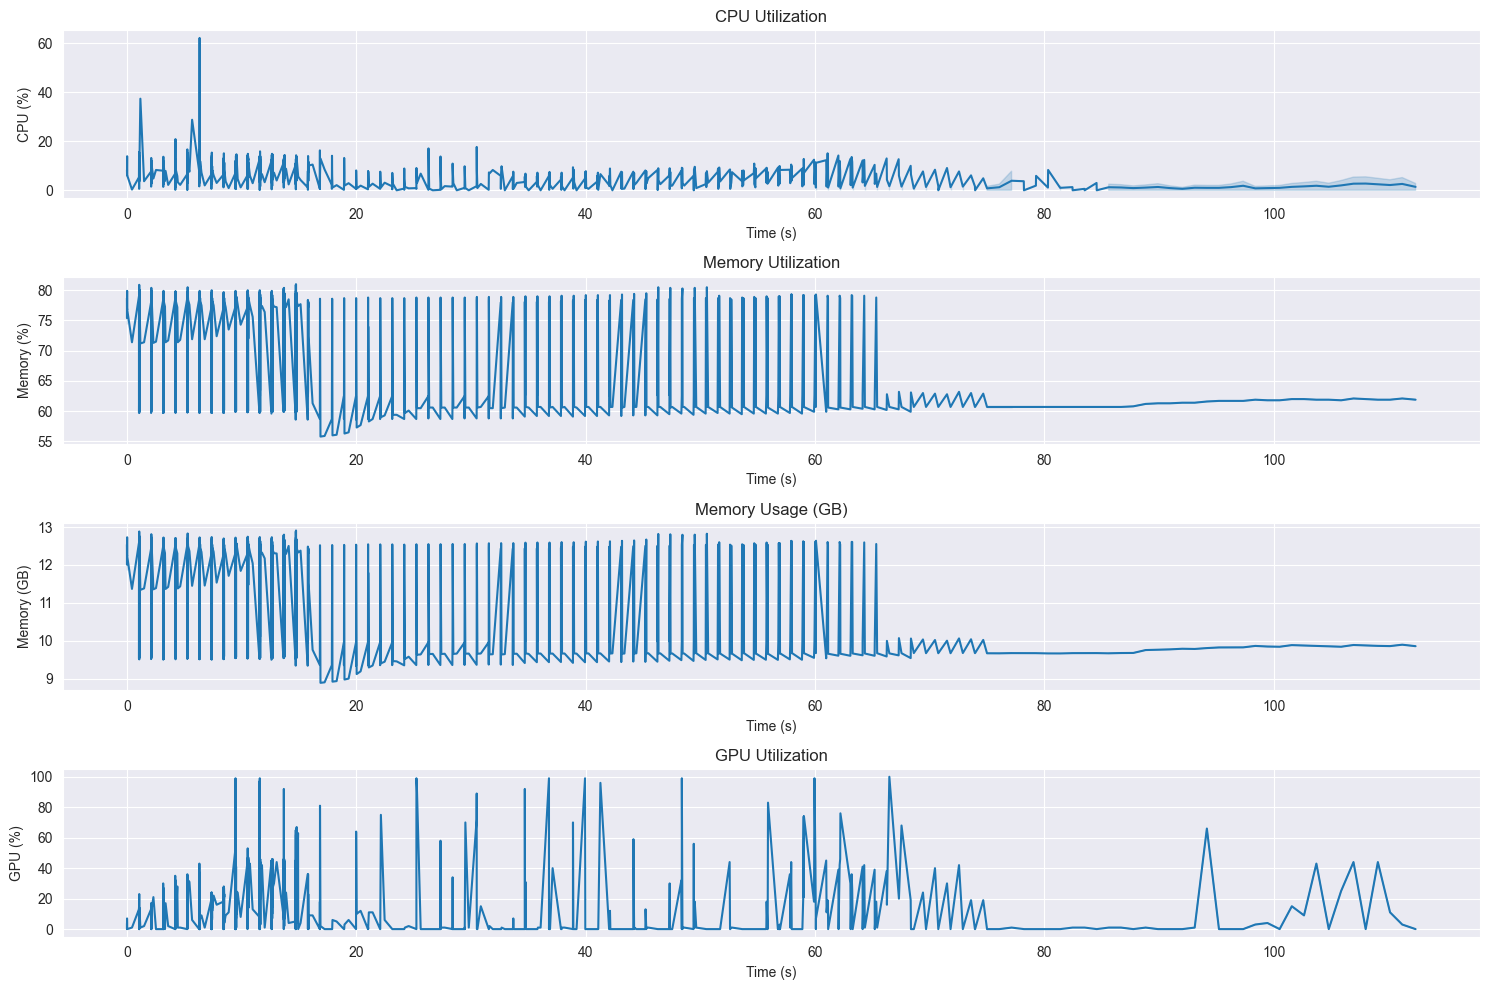

In [17]:
monitor.stop()
monitor.plot_resources()

In [57]:
train_generator.cleanup()
valid_generator.cleanup()

2024-11-13 07:10:55,772 - INFO - Successfully cleaned up resources
2024-11-13 07:10:55,780 - INFO - Successfully cleaned up resources
